In [1]:
import time
import numpy as np

from env.cartpole import CartPole
from env.system import ControlSystem, Controller, LinearQuadraticRegulator
from base.construct import Construct
from base.utilities import *

import torch
torch.set_printoptions(precision=6)
torch.set_flush_denormal(True)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

import matplotlib.pyplot as plt

In [2]:
# Define the device (cpu or cuda) and the control system object.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Send the control system object to device.
cs = ControlSystem()
cs.to(device)

ControlSystem(
  (controller): Controller(
    (fcl): ModuleList(
      (0): Linear(in_features=4, out_features=1, bias=False)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (loss_fn): TrajectoryLoss()
)

## Data generation and preparation

The cell below generates and prepares the data to be sent to the training routine.  
There is no need to change this cell. However, if you want, you can play with 
the batch_size and the total number of data points to train on.

In [3]:
torch.manual_seed(17)

batch_size = 4
total_size = batch_size * 60

x_train_tensor = torch.empty((0,cs.robot.num_states))
x_val_tensor = torch.empty((0,cs.robot.num_states))
for _ in range(total_size):
    x_train_tensor = torch.cat((x_train_tensor,
                    torch.reshape(cs.robot.random_state(), 
                                  (1,cs.robot.num_states))), dim=0)
    x_val_tensor = torch.cat((x_val_tensor,
                    torch.reshape(cs.robot.random_state(), 
                                  (1,cs.robot.num_states))), dim=0)
y_train_tensor = torch.zeros((len(x_train_tensor), 1))
y_val_tensor = torch.zeros((len(x_val_tensor), 1))

# Build data set containing all data zpoints
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Build a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

## Create the loss function and the optimizer

The cell below defines the loss function and the optimizer.

In [4]:
loss_fn = nn.L1Loss() # define an L1 loss function.

optimizer = optim.Adam(cs.parameters(), lr=0.0001)  # set the learning rate (gradient descent step size) here.

In [5]:
print(f"Number of trainable parameters: {count_parameters(cs)}")
for name, layer in cs.named_modules():
    print(name)
cs

Number of trainable parameters: 4

controller
controller.fcl
controller.fcl.0
controller.dropout
loss_fn


ControlSystem(
  (controller): Controller(
    (fcl): ModuleList(
      (0): Linear(in_features=4, out_features=1, bias=False)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (loss_fn): TrajectoryLoss()
)

## Test the performance of the initial neural net vs linear quadratic regulator

In [6]:
# Define the linear quadratic regulator and print its gains.  
# Simulate 30 trajectories starting from the same initial condition (selected randomly)
# with the neural net controller and the linear quadratic regulator.
# Compute the performance of each controller and print the average performance ratio
# defined as neural net performance / lqr performance.

c = LinearQuadraticRegulator(device=device) # define lqr

print(f"LQR gains: {c.K}")
perf_ratio = 0
for k in range(30):
    torch.manual_seed(50)
    s0 = cs.robot.random_state()
    traj_learned, ctrl_learned = cs.robot.simulate(controller=cs.controller, s0=s0)
    traj_lqr, ctrl_lqr = cs.robot.simulate(controller=c, s0=s0)
    cur_ratio = cs.loss_fn(traj_learned, ctrl_learned).item()/cs.loss_fn(traj_lqr, ctrl_lqr).item()
    perf_ratio = perf_ratio + cur_ratio 
print("--- Before training ---")
print(f"Performance ratio: {(perf_ratio/30)*100}%")

LQR gains: tensor([[-0.707107, 23.456890, -2.427715,  4.041519]])
--- Before training ---
Performance ratio: 1579.86045350122%


## Create the machine learning pipeline and train for n epochs.

In [7]:
# Construct the machine learning pipeline object here.
# - It will want the control system object, the loss function, the optimizer for training.
# Send this object to the device you want the training done.
# Set training and validation data loaders for the pipeline.

prob = Construct(cs, loss_fn, optimizer)
prob.to(device)
prob.set_loaders(train_loader, val_loader)

In [8]:
# Set the number of epochs for training and train for that many epochs.

n_epochs = 10
start_time = time.time()
prob.capture_gradients(['controller.fcl.0', 'controller.fcl.1', 'controller.fcl.2', 
                        'controller.fcl.3'])
prob.train(n_epochs)
prob.remove_hooks()
print("--- %s seconds ---" % (time.time() - start_time))

[Epoch 0] loss: 0.218494 | % loss: 100.0%
[Epoch 1] loss: 0.217943 | % loss: 99.7%
[Epoch 2] loss: 0.219476 | % loss: 100.4%
[Epoch 3] loss: 0.218917 | % loss: 100.2%
[Epoch 4] loss: 0.215167 | % loss: 98.5%
[Epoch 5] loss: 0.215340 | % loss: 98.6%
[Epoch 6] loss: 0.214894 | % loss: 98.4%
[Epoch 7] loss: 0.217701 | % loss: 99.6%
[Epoch 8] loss: 0.216124 | % loss: 98.9%
[Epoch 9] loss: 0.213430 | % loss: 97.7%
--- 100.2825939655304 seconds ---


In [9]:
for p in cs.parameters():
    print(p)

Parameter containing:
tensor([[-0.734494,  0.083519,  0.263821, -0.604212]], requires_grad=True)


In [10]:
# This cell acquires the gradients during training for observation.
# Choose which gradient you want to observe here for your report.
# Discuss the behavior of the gradients with respect to the convergence of your model.

gradients0 = np.array(prob._gradients['controller.fcl.0']['weight']).squeeze()
print(gradients0.shape)
gradients = gradients0[:,3]

(600, 4)


In [11]:
# This cell normalizes and smooths out the gradients captured during training.

corrected_gradients = calc_corrected_ewma(gradients, 19)
corrected_sq_gradients = calc_corrected_ewma(np.power(gradients, 2), 1999)
adapted_gradients = corrected_gradients / (np.sqrt(corrected_sq_gradients) + 1e-8)

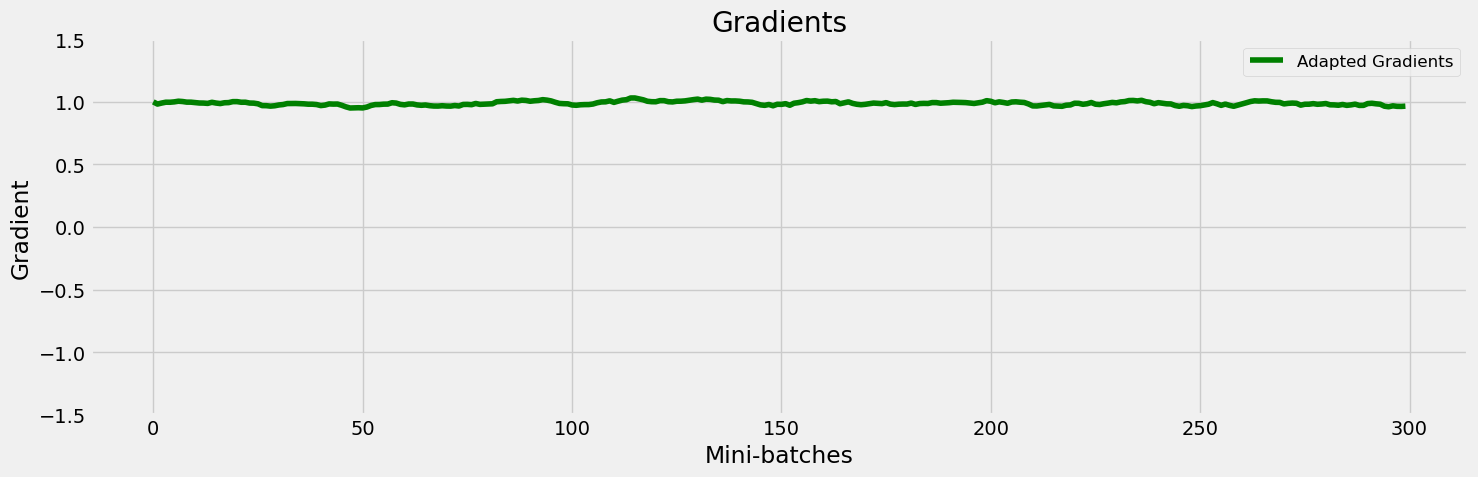

In [12]:
# This cell plots the gradients that are selected from the captured gradients.

fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.plot(adapted_gradients[:-300], c='g', label='Adapted Gradients')
axs.set_title('Gradients')
axs.set_ylabel('Gradient')
axs.set_xlabel('Mini-batches')
axs.set_ylim([-1.5, 1.5])
axs.legend(fontsize=12)
fig.tight_layout()

### Discussion of the behavior of the gradients with respect to the convergence of the model:
From the above plot, we observe the following;
* **Stability:** The gradient values appear to be quite stable across mini-batches. This indicates that the model's learning process is stable, and the gradients aren't experiencing significant fluctuations that could indicate instability in learning.

* **Magnitude:** The gradients are well within the set range of [-1.5, 1.5], which suggests there are no exploding gradients. Moreover, since the gradients are not near zero, vanishing gradients also do not appear to be an issue.

* **Consistency:** The plot shows a consistent gradient value with little noise, which suggests that the model is receiving consistent information from each mini-batch. This could indicate good generalization across the mini-batches.

## Verify that the training yields a good controller

In [13]:
# Reperform the performance comparison between the neural net controller and LQR.
# Simulate 30 trajectories starting from the same initial condition (selected randomly)
# with the neural net controller and the linear quadratic regulator.
# Compute the performance of each controller and print the average performance ratio
# defined as neural net performance / lqr performance.

perf_ratio = 0
for k in range(30):
    torch.manual_seed(50)
    s0 = cs.robot.random_state()
    traj_learned, ctrl_learned = cs.robot.simulate(controller=cs.controller, s0=s0)
    traj_lqr, ctrl_lqr = cs.robot.simulate(controller=c, s0=s0)
    cur_ratio = cs.loss_fn(traj_learned, ctrl_learned).item()/cs.loss_fn(traj_lqr, ctrl_lqr).item()
    perf_ratio = perf_ratio + cur_ratio
print("--- After training ---")    
print(f"Performance ratio: {(perf_ratio/30)*100}%")

--- After training ---
Performance ratio: 1210.33111759808%


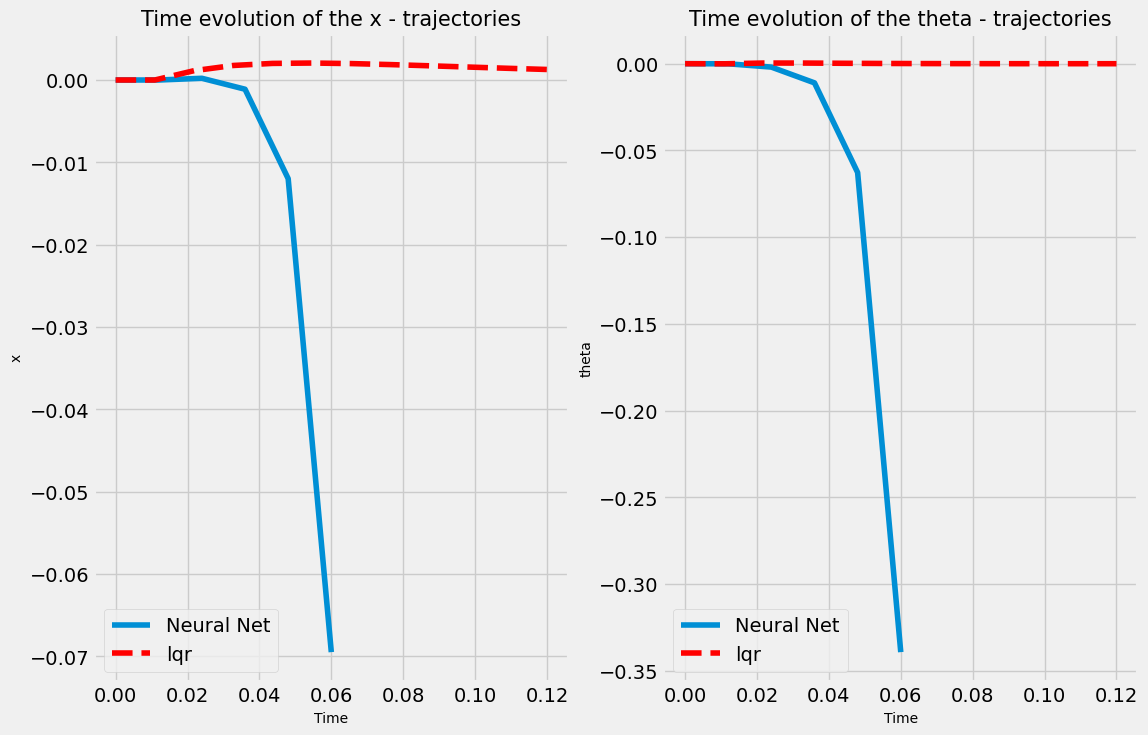

In [14]:
# Simulate a couple of sample trajectories starting from a random initial state
# One of these trajectories will be controller by the neural net, the other by LQR
# Plot the time evolution of these trajectories (x and theta) w.r.t. time on the same plots for easy comparison.
# Make the lqr trajectory dashdotted and the neural net solid.
# Also provide a plot of the used control authority, both from the lqr and the neural net.

s0 = cs.robot.random_state()
traj_learned, ctrl_learned = cs.robot.simulate(controller=cs.controller, s0=s0)
traj_lqr, ctrl_lqr = cs.robot.simulate(controller=c, s0=s0)

x_learned, theta_learned = traj_learned[:, 0].detach().numpy(), traj_learned[:, 1].detach().numpy()
x_lqr, theta_lqr = traj_lqr[:, 0].detach().numpy(), traj_lqr[:, 1].detach().numpy()


time_1 = np.linspace(0, len(x_learned) * cs.robot.delta_t, len(x_learned))
time_2 = np.linspace(0, len(x_lqr) * cs.robot.delta_t, len(x_lqr))


fig, axs = plt.subplots(1,2, figsize=(12,8))
axs[0].plot(time_1,x_learned,label='Neural Net')
axs[0].plot(time_2,x_lqr,'r--',label='lqr')
axs[0].set_title("Time evolution of the x - trajectories", fontsize = 15)
axs[0].set_xlabel('Time',fontsize = 10)
axs[0].set_ylabel('x',fontsize = 10)
axs[0].legend()

axs[1].plot(time_1,theta_learned,label='Neural Net')
axs[1].plot(time_2,theta_lqr,'r--',label='lqr')
axs[1].set_title("Time evolution of the theta - trajectories", fontsize = 15)
axs[1].set_xlabel('Time',fontsize = 10)
axs[1].set_ylabel('theta',fontsize = 10)
axs[1].legend()
plt.show()

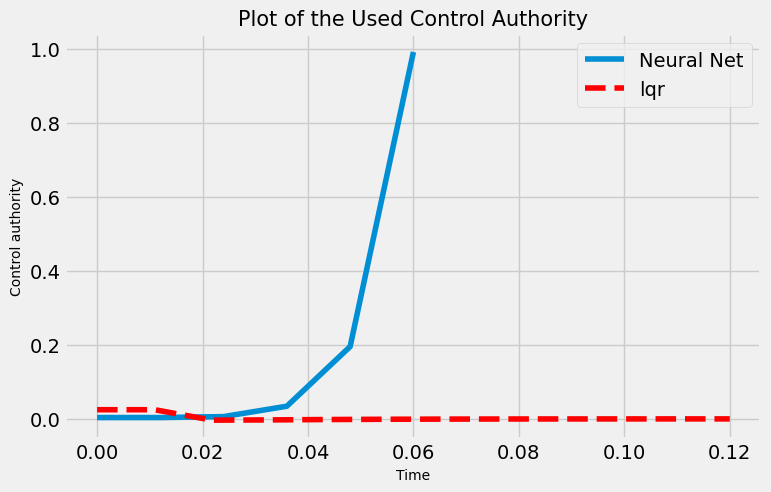

In [15]:
fig  = plt.figure(figsize=(8,5))
plt.plot(time_1,ctrl_learned.detach().numpy(),label='Neural Net')
plt.plot(time_2,ctrl_lqr.detach().numpy(),'r--',label='lqr')
plt.title("Plot of the Used Control Authority", fontsize = 15)
plt.xlabel('Time',fontsize = 10)
plt.ylabel('Control authority',fontsize = 10)
plt.legend()
plt.show()

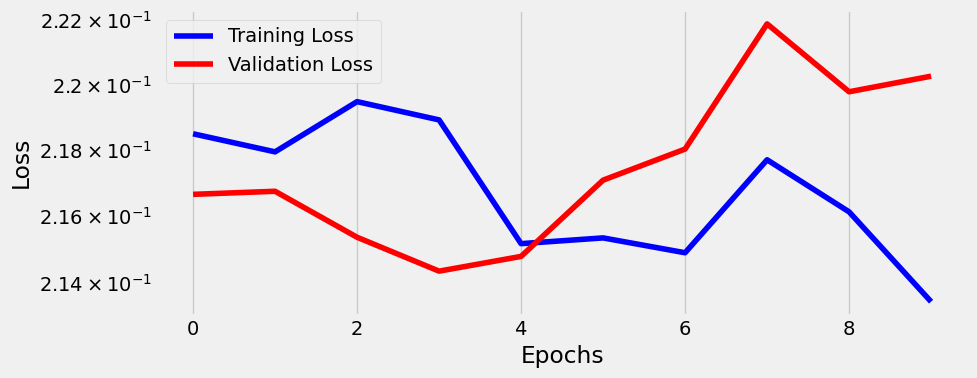

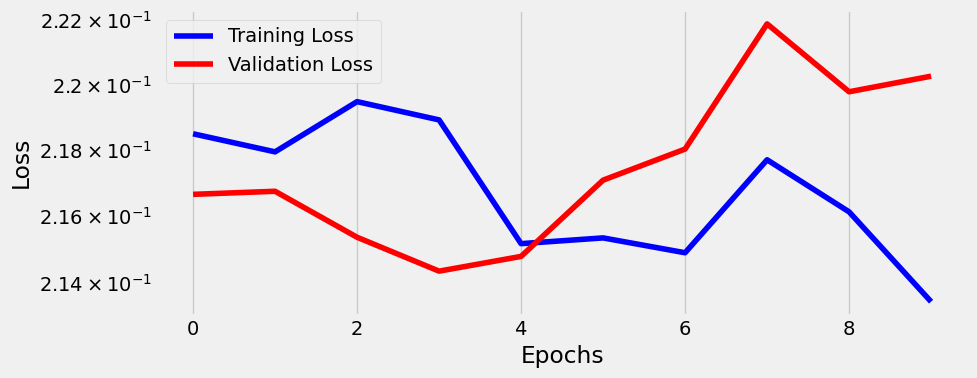

In [16]:
# This plots training losses obtained during training and then the validation 
# losses on the same plot. 
# Interpret these plots in your report.

prob.plot_losses()

## Monte Carlo Simulations

In [17]:
num_simulations = 1000
total_loss_lqr = 0
total_loss_nn = 0
for _ in range(num_simulations):
    torch.manual_seed(50)
    s0 = cs.robot.random_state()
    traj_learned, ctrl_learned = cs.robot.simulate(controller=cs.controller, s0=s0)
    traj_lqr, ctrl_lqr = cs.robot.simulate(controller=c, s0=s0)
    total_loss_nn += cs.loss_fn(traj_learned, ctrl_learned).item()
    total_loss_lqr += cs.loss_fn(traj_lqr, ctrl_lqr).item()

average_loss_nn = total_loss_nn / num_simulations
average_loss_lqr = total_loss_lqr / num_simulations

print(f"Average Loss - Neural Network: {average_loss_nn}")
print(f"Average Loss - lqr: {average_loss_lqr}")

Average Loss - Neural Network: 0.19012218713760376
Average Loss - lqr: 0.015708278864622116


From the above results, we see that the LQR controller performs better than the neural network